In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
from skopt import gp_minimize
import optuna
import random
import itertools
from math import log
import math

In [2]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([float(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates
filename = "TSP-Configurations/eil51.tsp.txt"
filename = "TSP-Configurations/a280.tsp.txt"
filename = "TSP-Configurations/pcb442.tsp.txt"

init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''
    Input: numpy arrays or tuples of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)
    '''
    city_a, city_b = np.array(city_a), np.array(city_b)
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''
    Input: OrderedDict with city names as keys and coordinates as values.
    Output: Total distance of the path that visits all cities once and returns to the starting city.
    '''
    city_coords = np.array(list(cities.values()))

    # Init variable: link last city with the first
    total_distance = get_distance(city_coords[-1], city_coords[0])

    # Connect every subsequent pair of cities
    for i in range(len(city_coords) - 1):
        total_distance += get_distance(city_coords[i], city_coords[i + 1])

    return total_distance


def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()

# Nearest Neighbour 

In [3]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step=100, init_seed=1056):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.max_step = max_step
        self.init_seed = init_seed
        self.step = 0

    def nearest_neighbor_heuristic(self):
        cities = list(self.cities_old.keys())
        current_city = random.choice(cities)
        solution = [current_city]

        while len(solution) < len(cities):
            distances = [(city, np.linalg.norm(np.array(self.cities_old[current_city]) - np.array(self.cities_old[city])))
                         for city in cities if city not in solution]
            next_city, _ = min(distances, key=lambda x: x[1])
            solution.append(next_city)
            current_city = next_city

        return OrderedDict((city, self.cities_old[city]) for city in solution)

    def proposal(self):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(self.cities_old.keys()))
        value = self.cities_old[random_key]

        proposal_cities = self.cities_old.copy()
        del proposal_cities[random_key]

        #Move it to here     
        new_index = np.random.randint(0, len(self.cities_old) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(self.cities_old.items())[:new_index] + [(random_key, value)] + list(self.cities_old.items())[new_index:])
        return proposal_cities


    def evaluate(self, cities, proposal_cities, T):
        delta_distance = total_distance(proposal_cities) - total_distance(cities)
        alpha_func = min(np.exp(-delta_distance / T), 1)
        return alpha_func

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            cities_new = proposal_cities
        else:
            cities_new = self.cities_old
        return cities_new

    def run(self):
        # Initial heuristic solution (nearest neighbor)
        initial_solution = self.nearest_neighbor_heuristic()
        self.cities_old = initial_solution

        while self.step < self.max_step:
            self.init_seed += 1
            T = (self.C * np.log(self.step + self.T0))**(-1)
            self.step += 1
            proposal_cities = self.proposal()
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new


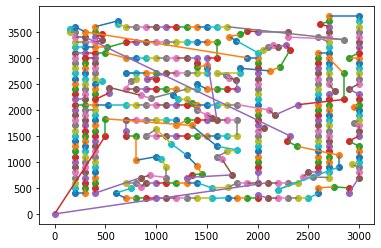

Total distance of simulated annealing solution is: 65000.06063074873
Order of the cities is as follows: odict_keys([236, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 415, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 235, 228, 406, 401, 186, 173, 162, 150, 137, 127, 386, 115, 104, 441, 102, 103, 114, 126, 136, 149, 161, 172, 185, 400, 405, 227, 234, 238, 239, 266, 269, 273, 276, 279, 281, 282, 428, 342, 341, 346, 347, 348, 433, 349, 350, 351, 352, 343, 353, 354, 355, 434, 356, 357, 358, 435, 359, 360, 361, 344, 362, 363, 364, 365, 366, 367, 345, 368, 369, 370, 371, 372, 373, 374, 375, 338, 337, 427, 336, 335, 334, 307, 333, 332, 331, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 280, 426, 440, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 429, 325, 326, 327, 328, 329, 330, 431, 430, 278, 417, 418, 232, 224, 215, 203, 191, 398, 178, 166, 155, 142,

In [4]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing(cities = init_cities, C = 0.8077887004677304, T0 = 50, max_step = 100)
    cities_new = sim_annealing.run()
    visualize_routes(cities_new)
    print(f'Total distance of simulated annealing solution is: {total_distance(cities_new)}')
    print(f'Order of the cities is as follows: {cities_new.keys()}')

In [5]:
# Load the TSP instances
eil51 = get_city_coord_dict("TSP-Configurations/eil51.tsp.txt")
a280 = get_city_coord_dict("TSP-Configurations/a280.tsp.txt")
pcb442 = get_city_coord_dict("TSP-Configurations/pcb442.tsp.txt")

# Define a function to run hyperparameter optimization for a given TSP instance
def optimize_tsp_instance(instance, study_name):
    # Define the objective function
    def objective(trial):
        # Define the hyperparameter search space
        T0 = trial.suggest_int('T0', 1, 1000)
        C = trial.suggest_float('C', 0.01, 1.0)
        # Create and run the SimulatedAnnealing instance with the chosen hyperparameters
        sa = SimulatedAnnealing(instance, C, T0, max_step = 500)
        optimized_cities = sa.run()

        # Calculate the objective value (in this case, the total distance)
        min_distance = total_distance(optimized_cities)

        return min_distance

    # Create an Optuna study
    study = optuna.create_study(direction='minimize', study_name=study_name)

    # Optimize the hyperparameters
    study.optimize(objective, n_trials=100)  # You can increase the number of trials for better results

    # Print the best hyperparameters and objective value
    print(f"Best trial for {study_name}:")
    best_trial = study.best_trial
    print("  Value: {:.2f}".format(best_trial.value))
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))

# Run hyperparameter optimization for each TSP instance
optimize_tsp_instance(eil51, "eil51_tsp_optimization")
optimize_tsp_instance(a280, "a280_tsp_optimization")
optimize_tsp_instance(pcb442, "pcb442_tsp_optimization")

[I 2023-12-15 16:43:50,328] A new study created in memory with name: eil51_tsp_optimization
[I 2023-12-15 16:43:50,727] Trial 0 finished with value: 521.0838748717058 and parameters: {'T0': 930, 'C': 0.9346069169858523}. Best is trial 0 with value: 521.0838748717058.
[I 2023-12-15 16:43:51,142] Trial 1 finished with value: 558.2323706629243 and parameters: {'T0': 144, 'C': 0.6565469961488004}. Best is trial 0 with value: 521.0838748717058.
[I 2023-12-15 16:43:51,516] Trial 2 finished with value: 577.1284155353437 and parameters: {'T0': 903, 'C': 0.043121963091814854}. Best is trial 0 with value: 521.0838748717058.
[I 2023-12-15 16:43:52,037] Trial 3 finished with value: 530.9316866658393 and parameters: {'T0': 537, 'C': 0.2118407658442006}. Best is trial 0 with value: 521.0838748717058.
[I 2023-12-15 16:43:52,438] Trial 4 finished with value: 511.9984277286615 and parameters: {'T0': 259, 'C': 0.9623321962202542}. Best is trial 4 with value: 511.9984277286615.
[I 2023-12-15 16:43:52,847

[I 2023-12-15 16:44:06,644] Trial 46 finished with value: 492.5010520397386 and parameters: {'T0': 618, 'C': 0.6237827714347832}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:07,035] Trial 47 finished with value: 554.2204094155729 and parameters: {'T0': 721, 'C': 0.6296071832276664}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:07,354] Trial 48 finished with value: 521.5197442784237 and parameters: {'T0': 920, 'C': 0.502197140386466}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:07,672] Trial 49 finished with value: 543.5144622463795 and parameters: {'T0': 622, 'C': 0.15406805974105708}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:08,000] Trial 50 finished with value: 514.8194490512965 and parameters: {'T0': 807, 'C': 0.2693984838592462}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:08,329] Trial 51 finished with value: 537.6990993574088 and parameters: {'T0': 426, 'C': 0.6871

[I 2023-12-15 16:44:22,392] Trial 93 finished with value: 548.2271061952237 and parameters: {'T0': 345, 'C': 0.5659554826908738}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:22,730] Trial 94 finished with value: 490.19074772761206 and parameters: {'T0': 461, 'C': 0.5929264701559663}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:23,139] Trial 95 finished with value: 532.1730491521922 and parameters: {'T0': 501, 'C': 0.5971976188981172}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:23,507] Trial 96 finished with value: 534.3784122342112 and parameters: {'T0': 417, 'C': 0.4842520853944386}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:23,866] Trial 97 finished with value: 542.7877351529975 and parameters: {'T0': 467, 'C': 0.5875506064723287}. Best is trial 5 with value: 484.6163258800161.
[I 2023-12-15 16:44:24,190] Trial 98 finished with value: 509.0900646386835 and parameters: {'T0': 273, 'C': 0.757

Best trial for eil51_tsp_optimization:
  Value: 484.62
  Params: 
    T0: 364
    C: 0.737770677729471


[I 2023-12-15 16:44:26,518] Trial 0 finished with value: 3050.0400469612973 and parameters: {'T0': 131, 'C': 0.1618902602367022}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:44:28,582] Trial 1 finished with value: 3445.8409022492538 and parameters: {'T0': 741, 'C': 0.05803430599896401}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:44:30,542] Trial 2 finished with value: 3229.752886041177 and parameters: {'T0': 542, 'C': 0.9600006684389475}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:44:32,419] Trial 3 finished with value: 3223.5305173992933 and parameters: {'T0': 420, 'C': 0.07190401303328112}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:44:34,487] Trial 4 finished with value: 3500.692232632134 and parameters: {'T0': 983, 'C': 0.49168341168256396}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:44:36,518] Trial 5 finished with value: 3280.905731644857 and parameters: {'T0': 73, 'C': 0.

[I 2023-12-15 16:46:02,444] Trial 45 finished with value: 3301.9100934233634 and parameters: {'T0': 43, 'C': 0.2256521009887675}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:46:05,853] Trial 46 finished with value: 3160.784045756778 and parameters: {'T0': 677, 'C': 0.061633071735746794}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:46:08,626] Trial 47 finished with value: 3214.0541194656616 and parameters: {'T0': 499, 'C': 0.1729958203845013}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:46:10,914] Trial 48 finished with value: 3525.516343689465 and parameters: {'T0': 188, 'C': 0.25394220721277466}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:46:13,173] Trial 49 finished with value: 3333.353854674072 and parameters: {'T0': 401, 'C': 0.14558446440224718}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:46:15,669] Trial 50 finished with value: 3269.321614309 and parameters: {'T0': 615, 'C':

[I 2023-12-15 16:47:55,696] Trial 91 finished with value: 3301.778860314213 and parameters: {'T0': 773, 'C': 0.10796817128264927}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:47:57,790] Trial 92 finished with value: 3125.8332266683183 and parameters: {'T0': 12, 'C': 0.11699108873464198}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:47:59,865] Trial 93 finished with value: 3511.8016323362663 and parameters: {'T0': 14, 'C': 0.19828828301093088}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:48:01,951] Trial 94 finished with value: 3211.771557012662 and parameters: {'T0': 10, 'C': 0.14069149629753425}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:48:04,309] Trial 95 finished with value: 3332.966357261858 and parameters: {'T0': 95, 'C': 0.10372459929239082}. Best is trial 0 with value: 3050.0400469612973.
[I 2023-12-15 16:48:06,487] Trial 96 finished with value: 3380.834415238996 and parameters: {'T0': 56, 'C':

Best trial for a280_tsp_optimization:
  Value: 3050.04
  Params: 
    T0: 131
    C: 0.1618902602367022


[I 2023-12-15 16:48:16,835] Trial 0 finished with value: 60541.86518656254 and parameters: {'T0': 185, 'C': 0.04300978656836086}. Best is trial 0 with value: 60541.86518656254.
[I 2023-12-15 16:48:20,553] Trial 1 finished with value: 61042.40667019076 and parameters: {'T0': 269, 'C': 0.5669750711179747}. Best is trial 0 with value: 60541.86518656254.
[I 2023-12-15 16:48:24,307] Trial 2 finished with value: 60449.013827856914 and parameters: {'T0': 37, 'C': 0.7574238026152109}. Best is trial 2 with value: 60449.013827856914.
[I 2023-12-15 16:48:27,963] Trial 3 finished with value: 62241.259666264916 and parameters: {'T0': 11, 'C': 0.041677771469068925}. Best is trial 2 with value: 60449.013827856914.
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_87842/1117491539.py:42: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-delta_distance / T), 1)
[I 2023-12-15 16:48:31,625] Trial 4 finished with value: 62365.321470145114 and parameters: {'T0': 500, 'C': 0.24

[I 2023-12-15 16:51:03,112] Trial 45 finished with value: 61941.46124619827 and parameters: {'T0': 593, 'C': 0.18136927901516056}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:51:06,276] Trial 46 finished with value: 63107.06901595301 and parameters: {'T0': 498, 'C': 0.21344741114382543}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:51:09,429] Trial 47 finished with value: 63421.17113374639 and parameters: {'T0': 45, 'C': 0.2719225753566738}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:51:12,934] Trial 48 finished with value: 63522.97757354556 and parameters: {'T0': 340, 'C': 0.3270780755779279}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:51:16,416] Trial 49 finished with value: 61177.5761864469 and parameters: {'T0': 485, 'C': 0.4223429438991979}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:51:20,069] Trial 50 finished with value: 60665.78324895464 and parameters: {'T0': 288, 'C': 0

[I 2023-12-15 16:54:03,348] Trial 91 finished with value: 64214.028375840666 and parameters: {'T0': 754, 'C': 0.45059315389198296}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:54:07,496] Trial 92 finished with value: 63685.61221600821 and parameters: {'T0': 654, 'C': 0.4325234889904448}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:54:11,479] Trial 93 finished with value: 62035.8882766671 and parameters: {'T0': 101, 'C': 0.3090235577025405}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:54:16,647] Trial 94 finished with value: 62170.63944605328 and parameters: {'T0': 667, 'C': 0.3624127957974602}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:54:21,514] Trial 95 finished with value: 59702.84326118617 and parameters: {'T0': 722, 'C': 0.2833549732350369}. Best is trial 44 with value: 58562.81688466762.
[I 2023-12-15 16:54:26,570] Trial 96 finished with value: 60867.59658827151 and parameters: {'T0': 708, 'C': 

Best trial for pcb442_tsp_optimization:
  Value: 58562.82
  Params: 
    T0: 574
    C: 0.21932738777140884


In [6]:
# Set the random seed for reproducibility
random.seed()

# Generate 30 random seed numbers
random_seeds = [random.randint(1, 1000) for _ in range(30)]

# Print the generated random seed numbers
print(random_seeds)

[883, 839, 159, 195, 215, 138, 630, 802, 236, 497, 197, 655, 730, 267, 538, 370, 587, 542, 14, 810, 187, 952, 471, 721, 745, 488, 714, 436, 582, 532]
